In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import json

In [32]:
rs = np.random.RandomState(10)
d = rs.normal(size=100)

In [2]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from glob import glob

In [33]:
print(d)

[ 1.3315865   0.71527897 -1.54540029 -0.00838385  0.62133597 -0.72008556
  0.26551159  0.10854853  0.00429143 -0.17460021  0.43302619  1.20303737
 -0.96506567  1.02827408  0.22863013  0.44513761 -1.13660221  0.13513688
  1.484537   -1.07980489 -1.97772828 -1.7433723   0.26607016  2.38496733
  1.12369125  1.67262221  0.09914922  1.39799638 -0.27124799  0.61320418
 -0.26731719 -0.54930901  0.1327083  -0.47614201  1.30847308  0.19501328
  0.40020999 -0.33763234  1.25647226 -0.7319695   0.66023155 -0.35087189
 -0.93943336 -0.48933722 -0.80459114 -0.21269764 -0.33914025  0.31216994
  0.56515267 -0.14742026 -0.02590534  0.2890942  -0.53987907  0.70816002
  0.84222474  0.2035808   2.39470366  0.91745894 -0.11227247 -0.36218045
 -0.23218226 -0.5017289   1.12878515 -0.69781003 -0.08112218 -0.52929608
  1.04618286 -1.41855603 -0.36249918 -0.12190569  0.31935642  0.4609029
 -0.21578989  0.98907246  0.31475378  2.46765106 -1.50832149  0.62060066
 -1.04513254 -0.79800882  1.98508459  1.74481415 -1.

In [5]:
len_rs, len_ts = [], []
span_rs, span_ts = [], []
for item in glob('rumor/*.json'):
    data = json.load(open(item))
    len_rs.append(len(data))
    span_rs.append(int(data[-1]['t']) - int(data[0]['t']))
for item in glob('truth/*.json'):
    data = json.load(open(item))
    len_ts.append(len(data))
    span_ts.append(int(data[-1]['t']) - int(data[0]['t']))

In [6]:
print(np.max(len_rs), np.min(len_rs), np.max(len_ts), np.min(len_ts))
print(np.max(span_rs), np.max(span_ts))

59318 10 52157 10
123524203 121134650


(0, 5000)

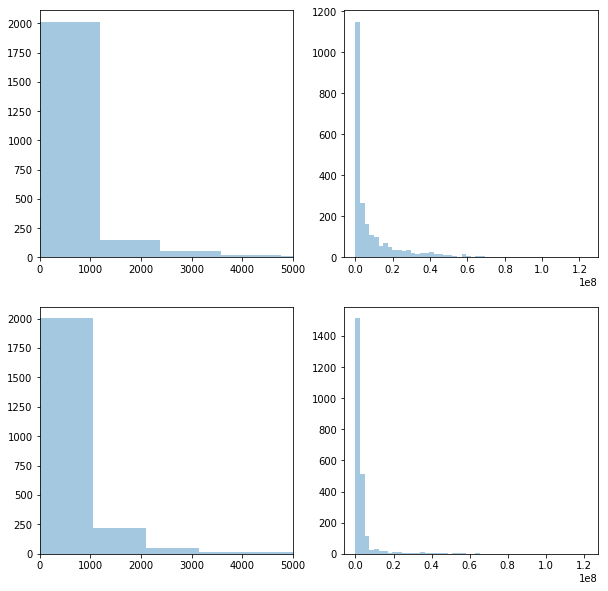

In [13]:
f, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.distplot(len_rs, kde=False, ax=axes[0][0])
sns.distplot(len_ts, kde=False, ax=axes[1][0])
sns.distplot(span_rs, kde=False, ax=axes[0][1])
sns.distplot(span_ts, kde=False, ax=axes[1][1])
axes[0][0].set_xlim(0, 5000)
axes[1][0].set_xlim(0, 5000)

In [61]:
len(rsample), len(tsample)

(4, 4)

In [23]:
np.zeros(10, dtype=int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

['rumor/3500763278016493.json' 'rumor/3506229823256156.json'
 'rumor/3512602401672717.json' 'rumor/3489202996195214.json']
['truth/3911733062474272.json' 'truth/13172370214.json'
 'truth/3911926532340747.json' 'truth/3431580661805230.json']


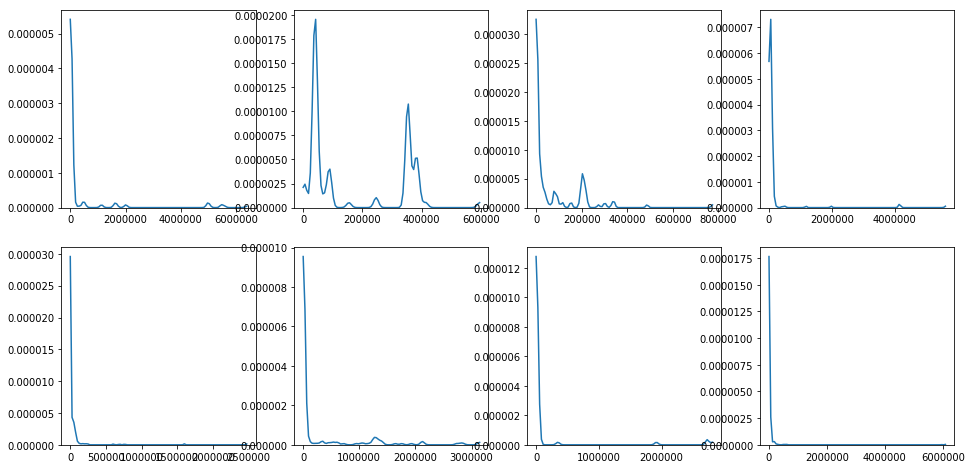

In [25]:
rsample = np.random.choice(glob('rumor/*.json'), size=4, replace=False)
tsample = np.random.choice(glob('truth/*.json'), size=4, replace=False)
f, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, item in enumerate(rsample):
    data = json.load(open(item))
    x = []
    begin = int(data[0]['t'])
    for post in data:
        x.append(int(post['t']) - begin)
    sns.kdeplot(x, bw=0.05, ax=axes[0][i])
    #axes[0][i].set_xlim(0, 50000)
for i, item in enumerate(tsample):
    data = json.load(open(item))
    x = []
    begin = int(data[0]['t'])
    for post in data:
        x.append(int(post['t']) - begin)
    sns.kdeplot(x, bw=0.05, ax=axes[1][i])
print(rsample)
print(tsample)

In [32]:
def lin_volumn(data, step=1000):
    begin = int(data[0]['t'])
    span = list(map(lambda x: int(x['t']) - begin, data))
    period = span[-1] / step
    volumn = list(map(lambda x: int(x / period) - 1, span))
    return volumn

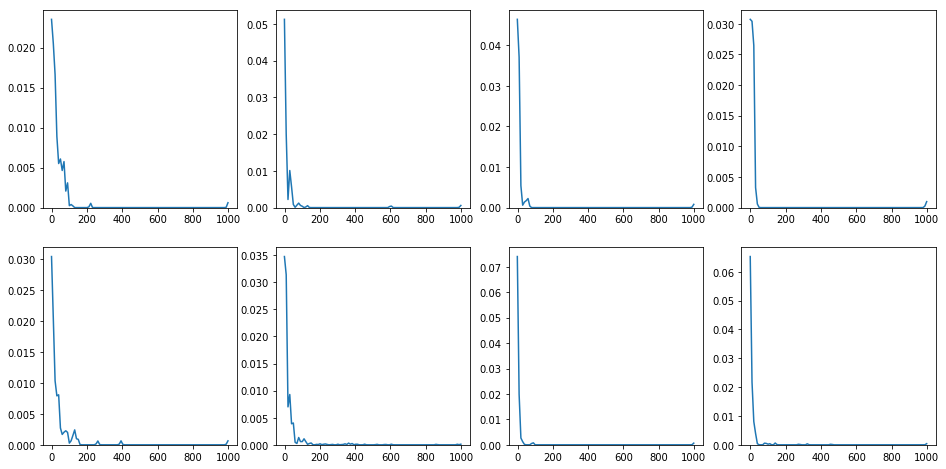

In [33]:
rsample = np.random.choice(glob('rumor/*.json'), size=4, replace=False)
tsample = np.random.choice(glob('truth/*.json'), size=4, replace=False)
f, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, item in enumerate(rsample):
    data = json.load(open(item))
    volumn = lin_volumn(data)
    sns.kdeplot(volumn, bw=0.05, ax=axes[0][i])
for i, item in enumerate(tsample):
    data = json.load(open(item))
    volumn = lin_volumn(data)
    sns.kdeplot(volumn, bw=0.05, ax=axes[1][i])

In [9]:
def log_volumn(data, step=100):
    begin = int(data[0]['t'])
    span = list(map(lambda x: max(0, int(x['t']) - begin) + 1, data))
    try:
        volumn = list(map(lambda x: int(x * step / 8.1), np.log10(span)))
    except:
        print(span)
        return None
    return volumn

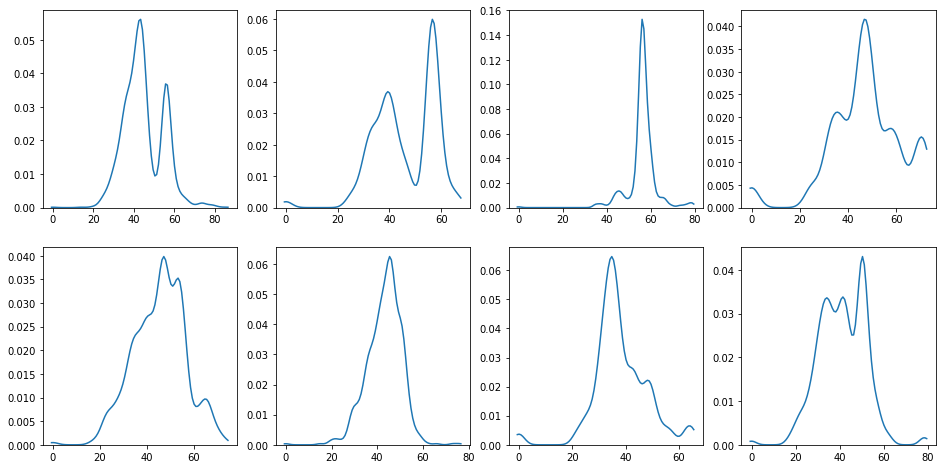

In [49]:
rsample = np.random.choice(glob('rumor/*.json'), size=4, replace=False)
tsample = np.random.choice(glob('truth/*.json'), size=4, replace=False)
f, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, item in enumerate(rsample):
    data = json.load(open(item))
    volumn = log_volumn(data)
    sns.kdeplot(volumn, bw=0.2, ax=axes[0][i])
for i, item in enumerate(tsample):
    data = json.load(open(item))
    volumn = log_volumn(data)
    sns.kdeplot(volumn, bw=0.2, ax=axes[1][i])

In [10]:
rsample = glob('rumor/*.json')
tsample = glob('truth/*.json')
#f, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, item in enumerate(rsample):
    data = json.load(open(item))
    volumn = log_volumn(data)
    #sns.kdeplot(volumn, bw=0.2, ax=axes[0][i])
for i, item in enumerate(tsample):
    data = json.load(open(item))
    volumn = log_volumn(data)
    #sns.kdeplot(volumn, bw=0.2, ax=axes[1][i])